__1__. Реализовать адаптивный бустинг использующий Логистическую Регрессию и меру ошибок LogLoss. Сравнить с точностью адаптивного бустинга на деревьях решений. Для сбора предсказаний можно использовать ту же функцию predict что и для бустинга на деревьях

__Примечания:__ в LogLoss необходимо передавать не предсказания полученные с помощью clf.predict(...), а вероятность, полученную с помощью clf.predict_proba(...)[:, 1]

In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import warnings
from sklearn import model_selection
import numpy as np

In [68]:
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)
def get_error(pred, y):
    return np.sum((pred != y).astype(int)) / len(y)

In [78]:
class logistic_regression:
    def __init__(self, n_iterations=1000, eta=0.05):
        self.n_iterations=1000
        self.eta=eta
    def _log_grad(self, X, target):
        m = X.shape[0]
        y=(2*target-1)
        score=np.dot(X, self.w.T).flatten()+self.w0
        Z=-y/(m*(1+np.exp(y*score)))
        grad=Z[np.newaxis, :].dot(X)
        return grad/m, np.sum(Z)/m
    def _optimize(self, X, target):
        for i in range(self.n_iterations):        
            grad_w, grad_w0 = self._log_grad(X, target)
            self.w = self.w-self.eta * grad_w
            self.w0 = self.w0 - self.eta * grad_w0
    def fit(self, X, target, w):
        self.w = w
        #self.w = np.zeros((1, X.shape[1]))
        self.w0=0
        self._optimize(X, target)
    def predict_test(self, X):  
        score=X.dot(self.w.T).flatten()+self.w0
        return 1/(1+np.exp(-score))
    def predict(self, X, thr=0.5):
        proba=self.predict_test(X)
        y_predicted = np.zeros(proba.shape, dtype=bool) 
        y_predicted[proba>thr]=1
        y_predicted[proba<=thr]=0
        return y_predicted

In [79]:
def log_loss(pred, y): return -np.sum(y*np.log2(pred)+(1-y)*np.log2(1-pred))/len(y)

In [80]:
def adaboost_log(X, y, N):

    # Размер выборки
    n_objects = len(X)

    # Запишем количество классов в переменную
    n_classes = len(np.unique((y)))

    # Начальные веса деревьев
    w = np.ones(n_objects) / n_objects

    # Деревья с весами будем записывать в список
    models = []

    for n in range(N):
        # Зададим дерево и обучим его
        log_classificator = LogisticRegression()

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            log_classificator.fit(X, y, w)
        predictions_test = log_classificator.predict_proba(X)[:, 1]
        e = log_loss(predictions_test, y)
        # отбросим дерево, если его ошибка больше 0.5
        # Запишем условие в общем виде (применимо к небинарным классификаторам)
        if e >= 1: 
            break

        # Вычислим вес для дерева
        alpha = 0.5 * np.log((1 - e) / e)

        # Найдем индексы правильно классифицированных элементов
        match = (predictions_test>0.5).astype(int) == y

        # Увеличим веса для неправильно классифицированных элементов
        w[np.logical_not(match)] *= np.exp(alpha)
        w[match] *= np.exp(-alpha)

        # Нормализуем веса
        w /= w.sum()

        # Добавим дерево с весом в список
        models.append((alpha, log_classificator))
    
    return models

In [81]:
N = 50

models = adaboost_log(X_train, y_train, N)

In [82]:
def predict_log(X, models):

    n_objects = len(X)
    
    # вначале обозначим предсказание нулевым массивом
    y_pred = np.zeros((n_objects,))
    
    for alpha, clf in models:
        score = clf.decision_function(X)
        # Для каждого предсказания будем прибавлять alpha к
        # элементу с индексом предсказанного класса
        y_pred += alpha*score
    
    # выберем индексы с максимальными суммарными весами -
    # получим предсказанные алгоритмом классы
    
    return (y_pred>0).astype(int)

print(f'Точность алгоритма на обучающей выборке: {(1 - get_error(predict_log(X_train, models), y_train)) * 100:.3f}')
print(f'Точность алгоритма на тестовой выборке: {(1 - get_error(predict_log(X_test, models), y_test)) * 100:.3f}')

Точность алгоритма на обучающей выборке: 93.427
Точность алгоритма на тестовой выборке: 93.007


In [83]:
def predict(X, models, n_classes = 10):
    
    n_objects = len(X)
    
    # вначале обозначим предсказание нулевым массивом
    y_pred = np.zeros((n_objects, n_classes))
    
    for alpha, clf in models:
        prediction = clf.predict(X)
        # Для каждого предсказания будем прибавлять alpha к
        # элементу с индексом предсказанного класса
        y_pred[range(n_objects), prediction] += alpha
    
    # выберем индексы с максимальными суммарными весами -
    # получим предсказанные алгоритмом классы
    y_pred = np.argmax(y_pred, axis=1)
    
    return y_pred

print(f'Точность алгоритма на обучающей выборке: {(1 - get_error(predict(X_train, models), y_train)) * 100:.3f}')
print(f'Точность алгоритма на тестовой выборке: {(1 - get_error(predict(X_test, models), y_test)) * 100:.3f}')

Точность алгоритма на обучающей выборке: 93.662
Точность алгоритма на тестовой выборке: 93.007


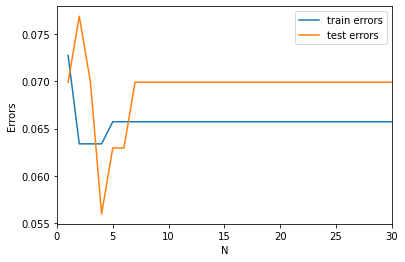

In [84]:
train_errors = []
test_errors = []

for n in range(1, 31):
    mods = adaboost_log(X_train, y_train, n)
    train_errors.append(get_error(predict_log(X_train, mods), y_train))
    test_errors.append(get_error(predict_log(X_test, mods), y_test))
x = list(range(1, 31))

plt.xlim(0, 30)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('N')
plt.ylabel('Errors')
plt.legend(loc='upper right')